In [127]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision
import tifffile as tiff
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from copy import deepcopy
import random


from collections import Counter
from scipy.stats import mode

In [128]:
# Set seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set seed
set_seed(42)

In [129]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [130]:
class SimCLR(nn.Module):
    def __init__(self, hidden_dim, lr, temperature, weight_decay,max_epochs):
        super().__init__()
        self.temperature = temperature
        
        # Load the pretrained ResNet-18 model
        self.convnet = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')
        
        # Modify the fully connected layer
        self.convnet.fc = nn.Sequential(
            nn.Linear(self.convnet.fc.in_features, 4 * hidden_dim),  # Linear layer with 4*hidden_dim output
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, 20)  # Output layer with hidden_dim output
        )

        self.optimizer = optim.AdamW(self.parameters(), lr=lr, weight_decay=weight_decay)
        self.lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=max_epochs, eta_min=lr / 50)

    def forward(self, x):
        return self.convnet(x)

    def info_nce_loss(self, imgs1, imgs2, device):

        imgs = torch.cat((imgs1, imgs2), dim=0)  # Concatenate along the batch dimension
        imgs = imgs.to(device)  # Move images to the device

        # Encode all images
        feats = self.forward(imgs)
    
        # Calculate cosine similarity
        cos_sim = nn.functional.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)
    
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
    
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)
    
        # Normalize similarity scores by temperature
        cos_sim = cos_sim / self.temperature

        # InfoNCE loss
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Accuracy calculations
        # Create a combination of positive and negative similarities for ranking
        comb_sim = torch.cat([cos_sim[pos_mask][:, None],  # Positive example in first position
                          cos_sim.masked_fill(pos_mask, -9e15)], dim=-1)
    
        # Sort and get the ranking position of the positive example
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
    
        # Compute accuracy metrics
        top1_acc = (sim_argsort == 0).float().mean()  # Top-1 accuracy
        top5_acc = (sim_argsort < 5).float().mean()   # Top-5 accuracy
        mean_pos = 1 + sim_argsort.float().mean()     # Mean position of the positive example

        return nll, top1_acc, top5_acc, mean_pos

    def train_epoch(self, train_loader, device):
        self.train()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        for batch in tqdm(train_loader, desc="Training", leave=False):
            imgs1, imgs2, _ = batch
            imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device
        
            self.optimizer.zero_grad()

            # Calculate loss and accuracy metrics
            loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

            loss.backward()
            self.optimizer.step()
            #self.lr_scheduler.step()

            # Accumulate metrics
            total_loss += loss.item()
            total_top1_acc += top1_acc.item()
            total_top5_acc += top5_acc.item()
            total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(train_loader)
        avg_top1_acc = total_top1_acc / len(train_loader)
        avg_top5_acc = total_top5_acc / len(train_loader)
        avg_mean_pos = total_mean_pos / len(train_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

    def validate_epoch(self, val_loader, device):
        self.eval()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validating", leave=False):
                imgs1, imgs2, _ = batch
                imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device

                # Calculate loss and accuracy metrics
                loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

                # Accumulate metrics
                total_loss += loss.item()
                total_top1_acc += top1_acc.item()
                total_top5_acc += top5_acc.item()
                total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(val_loader)
        avg_top1_acc = total_top1_acc / len(val_loader)
        avg_top5_acc = total_top5_acc / len(val_loader)
        avg_mean_pos = total_mean_pos / len(val_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos
    

    def inference_epoch(self, inference_loader, device):
        self.eval()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        with torch.no_grad():
            for batch in tqdm(inference_loader, desc="Inferencing", leave=False):
                imgs1, imgs2, _ = batch
                imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device

                # Calculate loss and accuracy metrics
                loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

                # Accumulate metrics
                total_loss += loss.item()
                total_top1_acc += top1_acc.item()
                total_top5_acc += top5_acc.item()
                total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(inference_loader)
        avg_top1_acc = total_top1_acc / len(inference_loader)
        avg_top5_acc = total_top5_acc / len(inference_loader)
        avg_mean_pos = total_mean_pos / len(inference_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

In [131]:
full_model_path =  r'C:\Users\k54739\Bibi_new_thesis\saved_model\resize_simclr_modelepoch250.pth' 
simclr_model = torch.load(full_model_path)
simclr_model.to(device)
simclr_model.eval()

C:\Users\k54739\AppData\Local\Temp\ipykernel_21264\3495648145.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  simclr_model = torch.load(full_model_path)


SimCLR(
  (convnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

# Clustering

In [132]:
class LabeledImageDataset(Dataset):
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        #self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")

        # Normalize the 16-bit image to [0, 1]
        image = image.astype(np.float32) / 65535.0

        # Convert to a torch tensor and add channel dimension
        image = torch.tensor(image, dtype=torch.float32)
        
        # Apply resize transform
        image = self.resize_transform(image)

        label = self.labels[idx]

        return image, label

def load_data(root_dir):
    #classes = ['cond7_all', 'sd_only','ex'] #full dataset
    #classes = ['cond7_curated', 'sd_only','ex'] # curated full dataset


    #classes = ['uncure_cond7_40', 'sdonly_40','ex'] # 40 subset # 97.50
    #classes = ['cure_cond7_40', 'sdonly_40','ex'] 


    #inference
    #classes = ['cond7_all', 'sd_plus_dsclose','ex'] #full dataset
    #classes = ['cond7_curated', 'sd_plus_dsclose','ex'] # curated full dataset



    #classes = ['uncure_cond7_40', 'sd_plus_dsclose_40','ex'] # curated 40 subset inference
    classes = ['cure_cond7_40', 'sd_plus_dsclose_40','ex'] # curated 40 subset inference

    image_files = []
    labels = []

    for idx, class_name in enumerate(classes):
        class_dir = os.path.join(root_dir, class_name)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir) if file.endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        labels.extend([idx] * len(files))
    
    # Check if the labels correctly reflect the classes
    print("Label distribution:", {classes[i]: labels.count(i) for i in range(len(classes))})

    return image_files, labels


# Directories for labeled data
image_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\classification"

# Load data
image_files, labels = load_data(image_dir)

# Create the labeled datasets
labeled_dataset = LabeledImageDataset(image_files, labels)

# Define DataLoaders
batch_size = 16
loader_labeled = DataLoader(labeled_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=0)

Label distribution: {'cure_cond7_40': 40, 'sd_plus_dsclose_40': 40, 'ex': 40}


In [133]:
for anchor,label in loader_labeled:
    print(anchor.shape, label.shape, anchor.dtype)
    print(label)
    break

torch.Size([16, 3, 96, 96]) torch.Size([16]) torch.float32
tensor([2, 1, 0, 1, 0, 2, 0, 2, 0, 0, 2, 2, 2, 0, 0, 1])


In [134]:
@torch.no_grad()
def prepare_data_features(model, dataloader):
    # Prepare model
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)

    # Encode all images
    feats, labels = [], []
    for batch_imgs, batch_labels in tqdm(dataloader):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        print(f"Batch features shape: {batch_feats.shape}")
        print(f"Batch labels shape: {batch_labels.shape}")
        
        feats.append(batch_feats.detach().cpu())
        labels.append(batch_labels)

    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels, dim=0)
    
    print(f"Features shape after concatenation: {feats.shape}")
    print(f"Labels shape after concatenation: {labels.shape}")

    return torch.utils.data.TensorDataset(feats, labels)

In [135]:
# Extract features for train and test datasets
feats_simclr = prepare_data_features(simclr_model, loader_labeled)

 12%|█▎        | 1/8 [00:00<00:05,  1.39it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 25%|██▌       | 2/8 [00:01<00:04,  1.36it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 38%|███▊      | 3/8 [00:02<00:03,  1.37it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 50%|█████     | 4/8 [00:02<00:02,  1.37it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 62%|██████▎   | 5/8 [00:03<00:02,  1.40it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 75%|███████▌  | 6/8 [00:04<00:01,  1.39it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 88%|████████▊ | 7/8 [00:05<00:00,  1.37it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


100%|██████████| 8/8 [00:05<00:00,  1.46it/s]

Batch features shape: torch.Size([8, 512])
Batch labels shape: torch.Size([8])
Features shape after concatenation: torch.Size([120, 512])
Labels shape after concatenation: torch.Size([120])


In [136]:
# Convert features and labels to NumPy arrays
feats_np = feats_simclr.tensors[0].numpy()  # Features in shape (60, 512)
labels_np = feats_simclr.tensors[1].numpy()  # Corresponding labels

# Check the shapes
print("Shape of features (for K-Means):", feats_np.shape)
print("Shape of labels:", labels_np.shape)

Shape of features (for K-Means): (120, 512)
Shape of labels: (120,)


In [137]:

# K-Means initialization function
def kMeans_init_centroids(X, K):
    randidx = np.random.permutation(X.shape[0])
    centroids = X[randidx[:K]]
    return centroids

# Function to find the closest centroids
def find_closest_centroids(X, centroids):
    idx = np.zeros(X.shape[0], dtype=int)
    for i in range(X.shape[0]):
        distances = np.linalg.norm(X[i] - centroids, axis=1)
        idx[i] = np.argmin(distances)
    return idx

# Function to compute new centroids
def compute_centroids(X, idx, K):
    centroids = np.zeros((K, X.shape[1]))  # Use shape[1] for features
    for k in range(K):
        points = X[idx == k]
        centroids[k] = np.mean(points, axis=0) if len(points) > 0 else centroids[k]
    return centroids

def run_kMeans(X, initial_centroids, max_iters=10):
    K = initial_centroids.shape[0]
    centroids = initial_centroids
    idx = np.zeros(X.shape[0])

    for i in range(max_iters):
        
        # Assign each data point to the closest centroid
        idx = find_closest_centroids(X, centroids)
        
        # Compute new centroids
        centroids = compute_centroids(X, idx, K)
    return centroids,idx

def calculate_accuracy(idx, labels_np, K=3):
    """Calculate accuracy for a given set of cluster assignments."""
    total_samples = len(labels_np)
    cluster_label_counts = {}
    label_to_cluster = {}
    correctly_classified = 0

    # Count true labels in each cluster
    for cluster in range(K):
        cluster_indices = np.where(idx == cluster)[0]
        cluster_labels = labels_np[cluster_indices]
        label_counts = Counter(cluster_labels)
        cluster_label_counts[cluster] = label_counts
    
    # Assign each label to the cluster where it is most common
    for label in range(3):  # Assuming 3 classes: 0, 1, 2
        max_count = 0
        assigned_cluster = None
        for cluster, label_counts in cluster_label_counts.items():
            if label_counts[label] > max_count:
                max_count = label_counts[label]
                assigned_cluster = cluster
        if assigned_cluster is not None:
            label_to_cluster[label] = assigned_cluster
            correctly_classified += max_count

    accuracy = correctly_classified / total_samples
    return accuracy, cluster_label_counts 

def main_kMeans_experiment(X, labels_np, K=3, num_runs=100, max_iters=50):
    accuracies = []
    best_accuracy = 0
    best_cluster_counts = None
    best_centroids = None
    best_idx = None

    for run in range(num_runs):
        # Initialize centroids randomly
        initial_centroids = kMeans_init_centroids(X, K)
        
        # Run K-Means
        centroids, idx = run_kMeans(X, initial_centroids, max_iters)
        
        # Calculate accuracy
        accuracy, cluster_counts = calculate_accuracy(idx, labels_np, K)
        accuracies.append(accuracy)
        
        # Track the best run
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_cluster_counts = cluster_counts
            best_centroids = centroids
            best_idx = idx
        
        print(f"Run {run + 1}/{num_runs}, Accuracy: {accuracy:.4f}")

    # Print final results
    print("\n=== Final Results ===")
    print(f"Max Accuracy: {best_accuracy:.4f}")
    print("Cluster Descriptions:")
    for cluster, counts in best_cluster_counts.items():
        print(f"Cluster {cluster} has true labels: {counts}")
    
    # Return the best centroids and idx along with accuracy
    return best_accuracy, best_centroids, best_idx, best_cluster_counts


K = 3  # Number of clusters
num_runs = 400  # Number of K-Means runs
max_iters = 50  # Maximum iterations per run

best_accuracy, best_centroids, best_idx, best_cluster_counts = main_kMeans_experiment(feats_np, labels_np, K, num_runs, max_iters)

Run 1/400, Accuracy: 0.8000
Run 2/400, Accuracy: 0.8083
Run 3/400, Accuracy: 0.7917
Run 4/400, Accuracy: 0.8167
Run 5/400, Accuracy: 0.8167
Run 6/400, Accuracy: 0.8083
Run 7/400, Accuracy: 0.8667
Run 8/400, Accuracy: 0.8667
Run 9/400, Accuracy: 0.8083
Run 10/400, Accuracy: 0.8083
Run 11/400, Accuracy: 0.8250
Run 12/400, Accuracy: 0.8000
Run 13/400, Accuracy: 0.7917
Run 14/400, Accuracy: 0.8083
Run 15/400, Accuracy: 0.8667
Run 16/400, Accuracy: 0.8583
Run 17/400, Accuracy: 0.7833
Run 18/400, Accuracy: 0.8167
Run 19/400, Accuracy: 0.8583
Run 20/400, Accuracy: 0.8583
Run 21/400, Accuracy: 0.8250
Run 22/400, Accuracy: 0.8083
Run 23/400, Accuracy: 0.8667
Run 24/400, Accuracy: 0.7917
Run 25/400, Accuracy: 0.7917
Run 26/400, Accuracy: 0.8583
Run 27/400, Accuracy: 0.8083
Run 28/400, Accuracy: 0.8167
Run 29/400, Accuracy: 0.8000
Run 30/400, Accuracy: 0.8083
Run 31/400, Accuracy: 0.8250
Run 32/400, Accuracy: 0.8083
Run 33/400, Accuracy: 0.8417
Run 34/400, Accuracy: 0.7917
Run 35/400, Accuracy: 0

In [138]:
num= 180+125

In [139]:
num/637

0.478806907378336

In [140]:

# K-Means initialization function
def kMeans_init_centroids(X, K):
    randidx = np.random.permutation(X.shape[0])
    centroids = X[randidx[:K]]
    return centroids

# Function to find the closest centroids
def find_closest_centroids(X, centroids):
    idx = np.zeros(X.shape[0], dtype=int)
    for i in range(X.shape[0]):
        distances = np.linalg.norm(X[i] - centroids, axis=1)
        idx[i] = np.argmin(distances)
    return idx

# Function to compute new centroids
def compute_centroids(X, idx, K):
    centroids = np.zeros((K, X.shape[1]))  # Use shape[1] for features
    for k in range(K):
        points = X[idx == k]
        centroids[k] = np.mean(points, axis=0) if len(points) > 0 else centroids[k]
    return centroids

def run_kMeans(X, initial_centroids, max_iters=10):
    K = initial_centroids.shape[0]
    centroids = initial_centroids
    idx = np.zeros(X.shape[0])

    for i in range(max_iters):
        
        # Assign each data point to the closest centroid
        idx = find_closest_centroids(X, centroids)
        
        # Compute new centroids
        centroids = compute_centroids(X, idx, K)
    return centroids,idx

def calculate_accuracy(idx, labels_np, K=3):
    """Calculate accuracy for a given set of cluster assignments."""
    total_samples = len(labels_np)
    cluster_label_counts = {}
    label_to_cluster = {}
    correctly_classified = 0

    # Count true labels in each cluster
    for cluster in range(K):
        cluster_indices = np.where(idx == cluster)[0]
        cluster_labels = labels_np[cluster_indices]
        label_counts = Counter(cluster_labels)
        cluster_label_counts[cluster] = label_counts
    
    # Track clusters already assigned to labels
    assigned_clusters = set()

    # Assign each label to the cluster where it is most common, respecting the rule
    for label in range(3):  # Assuming 3 classes: 0, 1, 2
        max_count = 0
        assigned_cluster = None
        for cluster, label_counts in cluster_label_counts.items():
            # Skip clusters already assigned to another label
            if cluster in assigned_clusters:
                continue
            if label_counts[label] > max_count:
                max_count = label_counts[label]
                assigned_cluster = cluster
        # Assign this label to the cluster and mark the cluster as used
        if assigned_cluster is not None:
            label_to_cluster[label] = assigned_cluster
            assigned_clusters.add(assigned_cluster)
            correctly_classified += max_count

    accuracy = correctly_classified / total_samples
    return accuracy, cluster_label_counts 

def main_kMeans_experiment(X, labels_np, K=3, num_runs=100, max_iters=50):
    accuracies = []
    best_accuracy = 0
    best_cluster_counts = None
    best_centroids = None
    best_idx = None

    for run in range(num_runs):
        # Initialize centroids randomly
        initial_centroids = kMeans_init_centroids(X, K)
        
        # Run K-Means
        centroids, idx = run_kMeans(X, initial_centroids, max_iters)
        
        # Calculate accuracy
        accuracy, cluster_counts = calculate_accuracy(idx, labels_np, K)
        accuracies.append(accuracy)
        
        # Track the best run
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_cluster_counts = cluster_counts
            best_centroids = centroids
            best_idx = idx
        
        print(f"Run {run + 1}/{num_runs}, Accuracy: {accuracy:.4f}")

    # Print final results
    print("\n=== Final Results ===")
    print(f"Max Accuracy: {best_accuracy:.4f}")
    print("Cluster Descriptions:")
    for cluster, counts in best_cluster_counts.items():
        print(f"Cluster {cluster} has true labels: {counts}")
    
    # Return the best centroids and idx along with accuracy
    return best_accuracy, best_centroids, best_idx, best_cluster_counts


K = 3  # Number of clusters
num_runs = 400  # Number of K-Means runs
max_iters = 50  # Maximum iterations per run

best_accuracy, best_centroids, best_idx, best_cluster_counts = main_kMeans_experiment(feats_np, labels_np, K, num_runs, max_iters)

Run 1/400, Accuracy: 0.7917
Run 2/400, Accuracy: 0.4833
Run 3/400, Accuracy: 0.8667
Run 4/400, Accuracy: 0.8000
Run 5/400, Accuracy: 0.8167
Run 6/400, Accuracy: 0.5250
Run 7/400, Accuracy: 0.8000
Run 8/400, Accuracy: 0.5000
Run 9/400, Accuracy: 0.5250
Run 10/400, Accuracy: 0.5250
Run 11/400, Accuracy: 0.7917
Run 12/400, Accuracy: 0.8250
Run 13/400, Accuracy: 0.8167
Run 14/400, Accuracy: 0.8083
Run 15/400, Accuracy: 0.5250
Run 16/400, Accuracy: 0.7917
Run 17/400, Accuracy: 0.5250
Run 18/400, Accuracy: 0.8667
Run 19/400, Accuracy: 0.8250
Run 20/400, Accuracy: 0.8000
Run 21/400, Accuracy: 0.7917
Run 22/400, Accuracy: 0.5250
Run 23/400, Accuracy: 0.4583
Run 24/400, Accuracy: 0.8083
Run 25/400, Accuracy: 0.8000
Run 26/400, Accuracy: 0.5250
Run 27/400, Accuracy: 0.8000
Run 28/400, Accuracy: 0.8250
Run 29/400, Accuracy: 0.8083
Run 30/400, Accuracy: 0.7917
Run 31/400, Accuracy: 0.8083
Run 32/400, Accuracy: 0.8083
Run 33/400, Accuracy: 0.4667
Run 34/400, Accuracy: 0.7917
Run 35/400, Accuracy: 0

In [141]:
s

NameError: name 's' is not defined

In [110]:
125+180

305

In [111]:
305/445


0.6853932584269663

In [16]:
103+330

433

In [17]:
433/615

0.7040650406504065

From scratch

In [36]:

# K-Means initialization function
def kMeans_init_centroids(X, K):
    randidx = np.random.permutation(X.shape[0])
    centroids = X[randidx[:K]]
    return centroids

# Function to find the closest centroids
def find_closest_centroids(X, centroids):
    idx = np.zeros(X.shape[0], dtype=int)
    for i in range(X.shape[0]):
        distances = np.linalg.norm(X[i] - centroids, axis=1)
        idx[i] = np.argmin(distances)
    return idx

# Function to compute new centroids
def compute_centroids(X, idx, K):
    centroids = np.zeros((K, X.shape[1]))  # Use shape[1] for features
    for k in range(K):
        points = X[idx == k]
        centroids[k] = np.mean(points, axis=0) if len(points) > 0 else centroids[k]
    return centroids

# Function to run K-Means algorithm with cost tracking
def run_kMeans(X, initial_centroids, max_iters=10):
    K = initial_centroids.shape[0]
    centroids = initial_centroids
    idx = np.zeros(X.shape[0])
    
    best_centroids = centroids
    lowest_cost = float('inf')
    final_iteration = 0  # To keep track of the iteration where the best centroids were found
    best_idx = idx

    for i in range(max_iters):
        #print(f"K-Means iteration {i}/{max_iters - 1}")
        
        # Assign each data point to the closest centroid
        idx = find_closest_centroids(X, centroids)
        
        # Compute new centroids
        centroids = compute_centroids(X, idx, K)

        # Calculate cost function for the current centroids
        cost = np.sum(np.linalg.norm(X - centroids[idx], axis=1)**2)
        #print(f"Cost function value: {cost:.4f}")  # Print the cost function value

        # Check if this is the best cost so far
        if cost < lowest_cost:
            lowest_cost = cost
            best_centroids = centroids
            best_idx = idx.copy()
            final_iteration = i  # Update the iteration where best centroids were found

    #print(f"Final centroids selected from iteration: {final_iteration}")  # Indicate which iteration was chosen
    return best_centroids, best_idx, centroids,idx  # Return the best centroids



In [37]:
K = 3                          # Step 2: Set number of clusters
initial_centroids = kMeans_init_centroids(feats_np, K)  # Step 3: Initialize centroids 
max_iters = 100                # Step 4: Number of iterations

best_centroids, best_idx, centroids, idx = run_kMeans(feats_np, initial_centroids, max_iters)  # Step 5: Run K-Means
#print("Final centroids:", best_centroids)  # Output the final centroids

from collections import Counter
import numpy as np

# Assuming `idx` contains the cluster assignments from KMeans
# and `labels` contains the true labels

K = len(np.unique(idx))  # Number of clusters

# Iterate over each cluster and count the true labels in that cluster
for cluster in range(K):
    # Find the indices of images assigned to the current cluster
    cluster_indices = np.where(idx == cluster)[0]
    
    # Get the true labels for the images in this cluster
    cluster_labels = labels_np[cluster_indices]
    
    # Use Counter to count occurrences of each label in the cluster
    label_counts = Counter(cluster_labels)
    
    # Print the result
    print(f"Cluster {cluster} has true labels: {label_counts}")

Cluster 0 has true labels: Counter({2: 40})
Cluster 1 has true labels: Counter({1: 40})
Cluster 2 has true labels: Counter({0: 40})


In [38]:
num = 274+95+8
print(num)

377


In [39]:
num = 300+103+38
print(num)

441


In [40]:
num/615

0.7170731707317073

In [41]:
from scipy.stats import mode
import numpy as np

# Function to reorder K-Means labels to match true labels
def reorder_labels(true_labels, predicted_labels):
    reordered_labels = np.zeros_like(predicted_labels)

    for cluster in np.unique(predicted_labels):
        mask = (predicted_labels == cluster)
        # Use mode and handle cases where mode() returns a scalar
        most_common_label = mode(true_labels[mask], axis=None).mode  # Get the mode for the current cluster
        if isinstance(most_common_label, np.ndarray):
            most_common_label = most_common_label[0]  # Safely extract the mode value if it's an array
        
        reordered_labels[mask] = most_common_label

    return reordered_labels




In [42]:
# Apply this after running K-Means
reordered_idx = reorder_labels(labels_np, idx)

# Now you can compare `reordered_idx` with `labels` to evaluate accuracy
accuracy = np.sum(reordered_idx == labels_np) / len(labels_np) * 100
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 100.00%


In [43]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [44]:
# Function to reduce the dimensionality of data points and centroids to 2D using PCA
def reduce_to_2D_pca(X, centroids):
    # Initialize PCA with 2 components
    pca = PCA(n_components=2)
    
    # Apply PCA to the data points (X) and centroids
    X_2D = pca.fit_transform(X)  # Reducing original data points
    centroids_2D = pca.transform(centroids)  # Reducing centroids

    return X_2D, centroids_2D

# Function to plot 2D visualization of clustered data points and centroids with true labels
def plot_2D_clusters_with_labels(X_2D, centroids_2D, idx, labels, K):
    plt.figure(figsize=(10, 7))
    
    # Define color map for clusters
    colors = plt.cm.rainbow(np.linspace(0, 1, K))
    
    # Plot data points colored by their cluster assignment
    for k in range(K):
        cluster_points = X_2D[idx == k]
        cluster_labels = labels[idx == k]  # Get true labels for the current cluster
        
        # Scatter plot for each cluster
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                    c=[colors[k]], label=f"Cluster {k+1}", alpha=0.6)
        
        # Annotate each point with its true label
        for i in range(cluster_points.shape[0]):
            plt.annotate(str(cluster_labels[i]), 
                         (cluster_points[i, 0], cluster_points[i, 1]), 
                         fontsize=8, alpha=0.75)

    # Plot centroids as larger markers
    plt.scatter(centroids_2D[:, 0], centroids_2D[:, 1], 
                c='k', marker='x', s=200, label='Centroids')

    plt.title("2D Visualization of Clusters using PCA with True Labels")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend()
    plt.grid()
    plt.show()


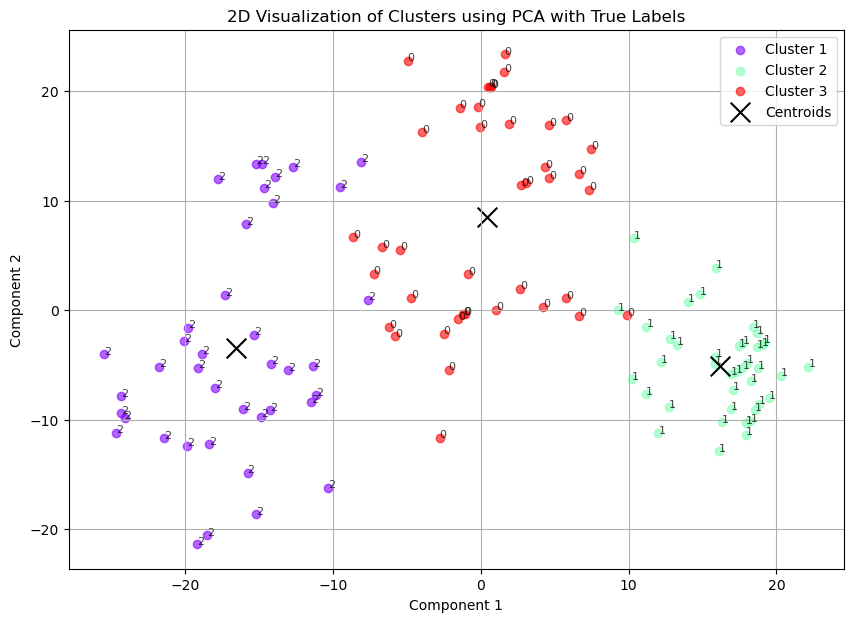

In [45]:
# Apply PCA after K-Means clustering for 2D visualization
X_2D_pca, centroids_2D_pca = reduce_to_2D_pca(feats_np, centroids)

# Plot the 2D clusters with centroids and true labels
plot_2D_clusters_with_labels(X_2D_pca, centroids_2D_pca, idx, labels_np, K)


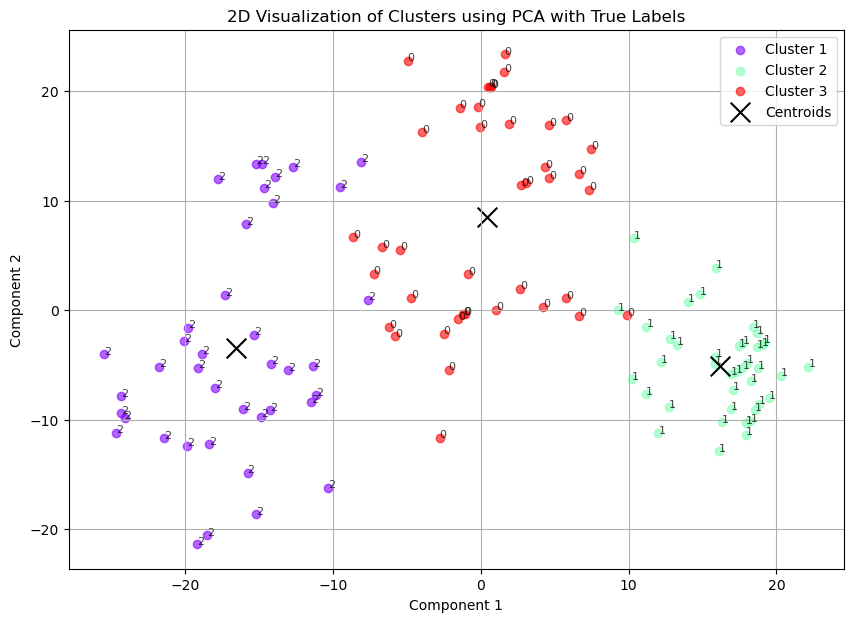

In [46]:
# Apply PCA after K-Means clustering for 2D visualization
X_2D_pca, centroids_2D_pca = reduce_to_2D_pca(feats_np, best_centroids)

# Plot the 2D clusters with centroids and true labels
plot_2D_clusters_with_labels(X_2D_pca, centroids_2D_pca, best_idx, labels_np, K)
